In [ ]:
!pip install --upgrade google-cloud-bigquery
!pip install google-cloud
!pip install google-cloud-storage
!pip install google-cloud-bigquery[pandas]
!pip install google-cloud-bigquery-storage
!pip install db-dtypes

In [114]:
from google.cloud import storage
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import os

%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [115]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'bigquery_json_key.json'

In [116]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agupt69\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\agupt69\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\agupt69\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [117]:
def list_buckets():
    storage_client = storage.Client()
    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

In [118]:
list_buckets()

[<Bucket: edu-uic-cs418-664474845-homework4>]


In [119]:
%%bigquery df

WITH responsetime_features AS (
  SELECT *
    , GREATEST(1, TIMESTAMP_DIFF(answers.first, creation_date, minute)) response_time
  FROM (
    SELECT id, creation_date, title
      , (SELECT AS STRUCT MIN(creation_date) first, COUNT(*) c
         FROM `bigquery-public-data.stackoverflow.posts_answers` 
         WHERE a.id=parent_id
      ) answers
      , SPLIT(tags, '|') tags
    FROM `bigquery-public-data.stackoverflow.posts_questions` a
    WHERE EXTRACT(year FROM creation_date) >= 2020 and EXTRACT(year FROM creation_date) <= 2021
  )
)


SELECT COUNT(*) questions, tag
  , ROUND(EXP(AVG(LOG(response_time))), 2) avg_response_time_min
  , FORMAT('%.2f', 100*COUNT(response_time)/COUNT(*)) answered_percent
FROM responsetime_features, UNNEST(tags) tag
GROUP BY tag
ORDER BY questions DESC

Downloading: 100%|██████████| 49733/49733 [00:01<00:00, 32327.52rows/s]


In [120]:
df["answered_percent"] = df["answered_percent"].astype(np.float32)

In [121]:
df

,questions,tag,avg_response_time_min,answered_percent
0,572193,python,57.24,77.349998
1,419231,javascript,49.36,76.820000
2,222717,java,94.49,73.230003
3,181032,reactjs,63.62,75.260002
4,162330,c#,109.70,74.449997
...,...,...,...,...
49728,1,skpaymentqueue,NaN,0.000000
49729,1,brep,NaN,0.000000
49730,1,ng-maxlength,2276.00,100.000000
49731,1,ammy,NaN,0.000000


In [122]:
df.to_csv("Responsetime_prediction_features.csv")

<BarContainer object of 10 artists>

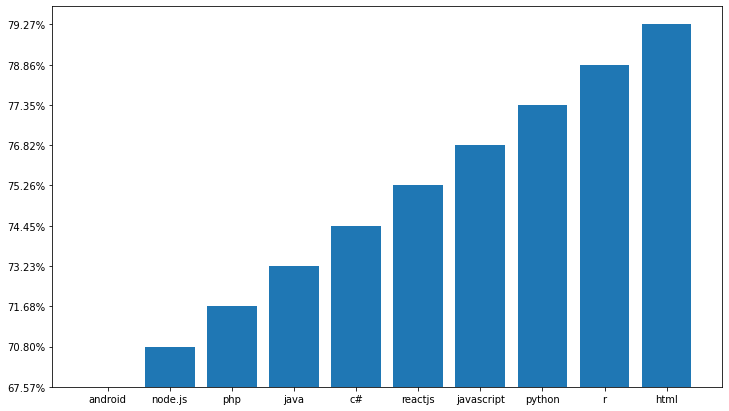

In [123]:
plot_df2 = df2.iloc[:10, : ].sort_values("chance_of_answer")
plt.figure(figsize=(12, 7))
plt.bar( plot_df2["tag"],plot_df2["chance_of_answer"])